In [3]:
import numpy as np
from tvb.simulator.lab import * 
from mpl_toolkits.mplot3d import Axes3D

from simulation import *
from tms_coil import *
from visualise import *
from stimulus import *
from utils import *

label_font = 16
title_font = 20
legend_font = 12

%pylab nbagg
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [4]:
PATH_TO_SC_HC = './data/HC/weights_HCP.txt'
PATH_TO_TRACT_LENGTHS = './data/HC/tract_lengths_HCP.txt'
PATH_TO_REGION_LABELS = './data/HC/region_labels_HCP.txt'

PATH_TO_TMS_ELECTRIC_FIELD = './data/electric_fields/ernie FC6/ernie_EF_normE.json'
# PATH_TO_TMS_ELECTRIC_FIELD = './data/electric_fields/ernie−leftM1/ernie_EF_normE.json'

### Visualise emperical data

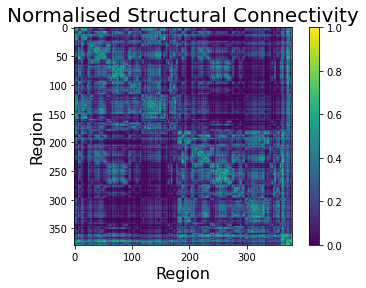

In [9]:
weights = np.log(np.loadtxt(PATH_TO_SC_HC)+1)
# normalise the SC
weights=(weights-np.min(weights))/(np.max(weights)-np.min(weights))

plt.imshow(np.asarray(weights))
plt.colorbar()
plt.title('Normalised Structural Connectivity', fontsize=title_font)
plt.xlabel('Region', fontsize=label_font)
plt.ylabel('Region', fontsize=label_font)
plt.show()

### Define TVB models

In [10]:
# TVB
dt = 1
neuron_model, heunint, default_cortex, white_matter, white_matter_coupling = get_brain_models(NMM='jansen_rit', 
                                                                                             path_to_SC=PATH_TO_SC_HC,
                                                                                             path_to_region_labels=PATH_TO_REGION_LABELS,
                                                                                             path_to_tract_lenghts=PATH_TO_TRACT_LENGTHS,
                                                                                             dt=dt
                                                                                             )

### Define TMS parameters

In [11]:
# using HCP MMP1 atlas
import json
with open(PATH_TO_TMS_ELECTRIC_FIELD, 'r') as f:
    electric_field_strength = json.load(f)

# renaming to match white_matter.region_labels
electric_field_strength = { f'L_{k[3:]}' if 'lh.' in k else f'R_{k[3:]}': v for k, v in electric_field_strength.items()}
# rearranging values and filling with zeros to match white_matter.region_labels order
electric_field_strength = np.array([electric_field_strength[area] if area in electric_field_strength.keys() else 0 for area in white_matter.region_labels])


coil = TMS_coil(type="fig8")
field_scale = 5e1
electric_field_strength = electric_field_strength * field_scale
coil.get_stimulus_distribution(electric_field_strength, white_matter.region_labels)

Region index    Region label    Stimulus weighting
55              R_6v            52.70347601562164
98              R_43            44.03300858131353
81              R_IFSa          41.134375844370055
73              R_44            39.560638711836475
74              R_45            37.8000364497121
82              R_p9-46v        37.33947939381036
80              R_IFSp          37.28220998498731
84              R_a9-46v        32.85905860882531
99              R_OP4           31.831999681620026
77              R_6r            31.46381903231554
174             R_A4            31.269567568233953
146             R_PFop          30.576416205870615
170             R_p47r          29.869477894486124
11              R_55b           29.55414907130512
115             R_PFt           29.415031361324033
75              R_47l           29.1024133860375
83              R_46            28.79113810069901
9               R_FEF           27.54838554059944
50              R_1             25.177346447

### Define TMS as stimulus

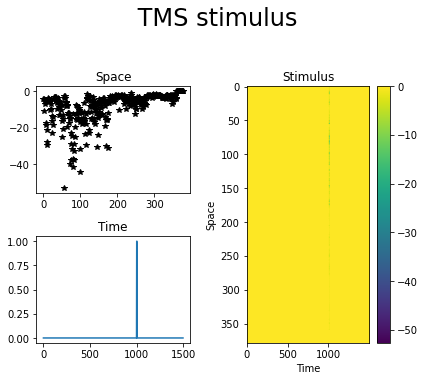

In [12]:
frequency = 500.0
stimulus_onset = 1e3
duration = 1.5e3

stimulus = get_stimulus(electric_field_strength*-1, white_matter, onset=stimulus_onset, frequency=frequency, duration=duration, type='rTMS', dt=dt)
plot_stimulus(stimulus)

### Define Monitors

In [13]:
monitors = get_monitors(["raw"])

### Define Simulators

In [17]:
rs_sim = simulator.Simulator(model=neuron_model,
                        connectivity=white_matter,
                        coupling=white_matter_coupling,
                        integrator=heunint,
                        monitors=monitors
                        )
rs_sim.configure()


# TMS simulation
tms_sim = simulator.Simulator(model=neuron_model,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint,
                          monitors=monitors,
                          stimulus=stimulus
                         )
tms_sim.configure()

In [35]:
# %%time
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

def run_sim(global_coupling=0, conduction_speed=3.0, a_1=1, a_2=0.8, a_3=0.25, a_4=0.25, plot=True, resting_state_sim=False):

    neuron_model.a_1 = np.array([a_1])
    neuron_model.a_2 = np.array([a_2])
    neuron_model.a_3 = np.array([a_3])
    neuron_model.a_4 = np.array([a_4])
    
    tms_sim = simulator.Simulator(model=neuron_model,
                            connectivity=white_matter,
                            coupling=white_matter_coupling,
                            integrator=heunint,
                            monitors=monitors,
                            stimulus=stimulus
                            )
    
    tms_sim.coupling.a = np.array([global_coupling])
    tms_sim.connectivity.speed = np.array([conduction_speed])
    
    tms_sim.configure()
    tms_data = run_simulation(tms_sim, duration, ["raw"])
    tavg_time, TAVG_TMS = tms_data["raw"]["time"], tms_data["raw"]["data"]
    
    if resting_state_sim:
        rs_sim = simulator.Simulator(model=neuron_model,
                        connectivity=white_matter,
                        coupling=white_matter_coupling,
                        integrator=heunint,
                        monitors=monitors
                        )
        
        rs_sim.coupling.a = np.array([global_coupling])
        rs_sim.connectivity.speed = np.array([conduction_speed])
        rs_sim.configure()
        rs_data = run_simulation(rs_sim, duration, ["raw"])
        tavg_time, TAVG_RS = rs_data["raw"]["time"], rs_data["raw"]["data"]

    x0=1000+30 #P30
    P30=find_roots(TAVG_TMS[:, 0, [9, 10, 11], 0].mean(axis=1), tavg_time-x0)
    
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(tavg_time, TAVG_TMS[:, 0, :, 0], "k", alpha=0.01)
        plt.plot(tavg_time, TAVG_TMS[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='TMS applied over M1')
        if resting_state_sim:
            plt.plot(tavg_time, TAVG_RS[:, 0, :, 0].mean(axis=1), alpha=1, label='Resting state')
        plt.title(f"{'Resting State vs ' if resting_state_sim else ''}TMS evoked potential; GC={global_coupling}, CS={conduction_speed}, a_1={a_1}, a_2={a_2}, a_3={a_3}, a_4={a_4}")
        plt.ylabel("Potential[y1-y2] (mV)")
        plt.xlabel("Time (ms)")
        plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
        plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
        
        
        try:
            plt.plot(np.ones_like(P30)*x0, P30, marker="o", ls="", ms=10, color="limegreen", label = f"{np.round(P30[0])}")
        except:
            pass
        plt.xlim(950, 1100)
        plt.ylim(-10,55)
        plt.legend()
        plt.show()
    
    return P30

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))


WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


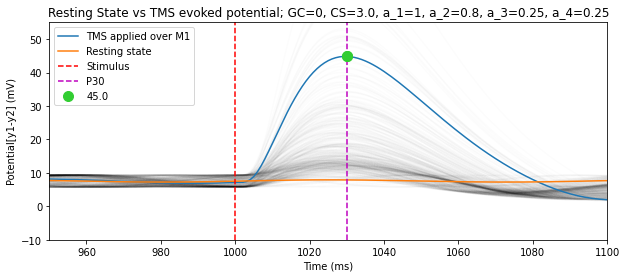

In [33]:
_ = run_sim(plot=True, resting_state_sim=True)

WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:,

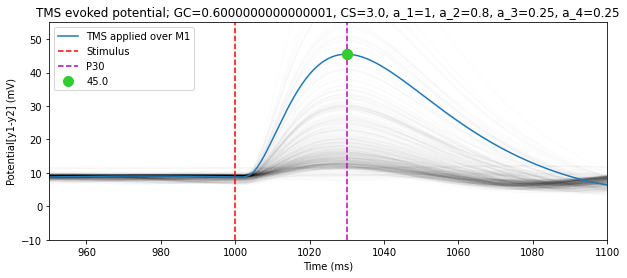

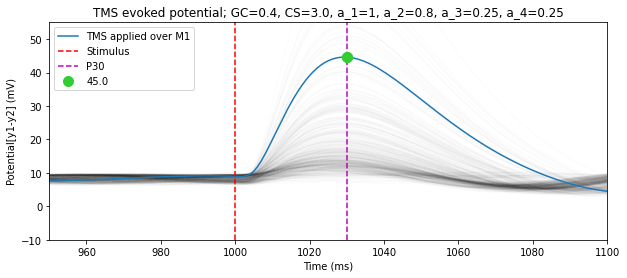

WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


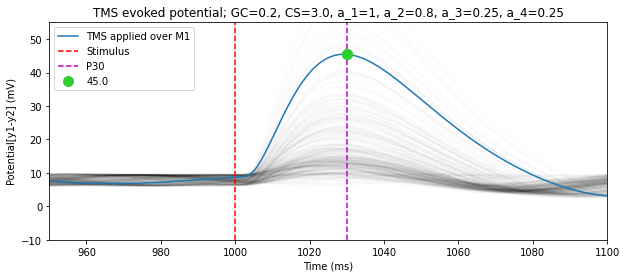

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


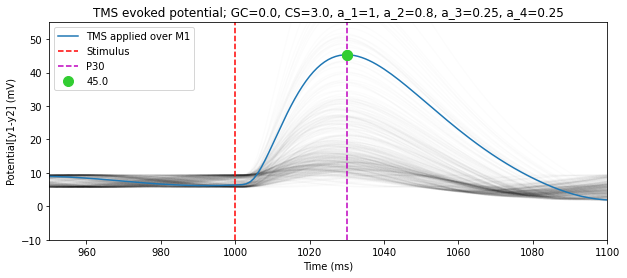

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


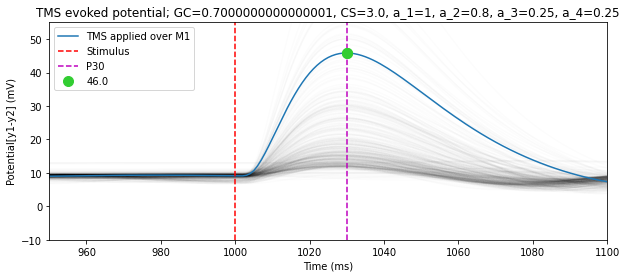

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


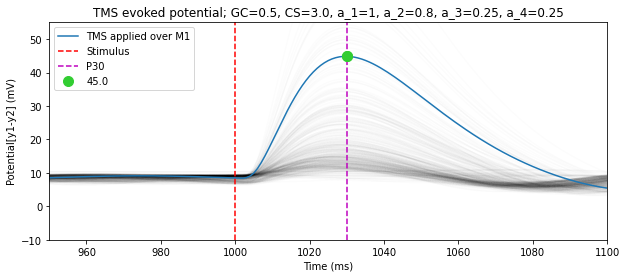

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


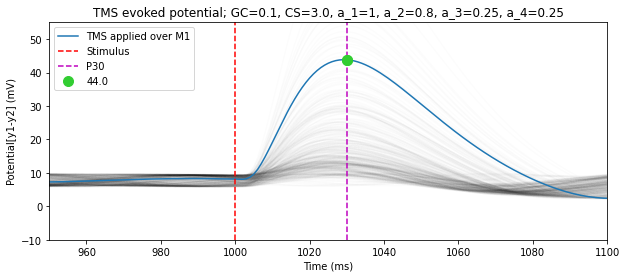

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


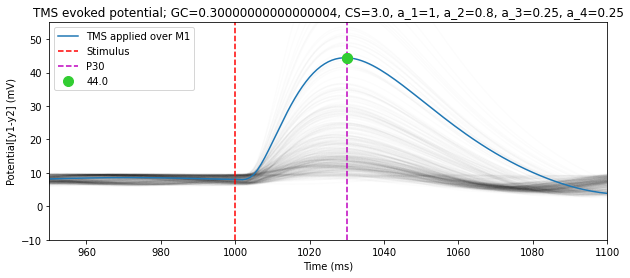

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


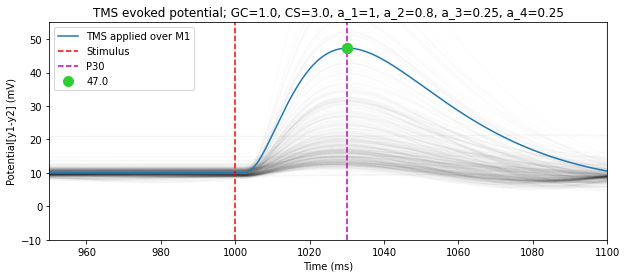

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from

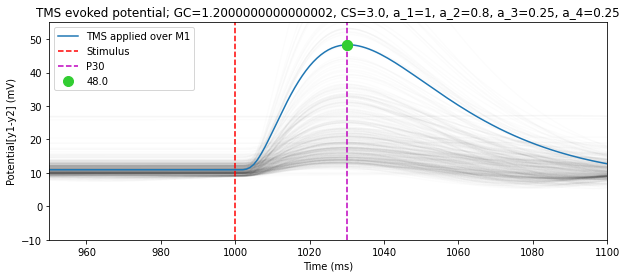

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


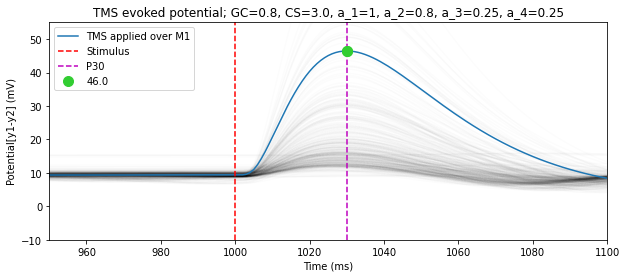

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


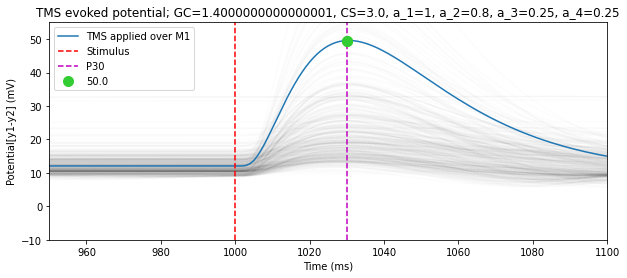

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


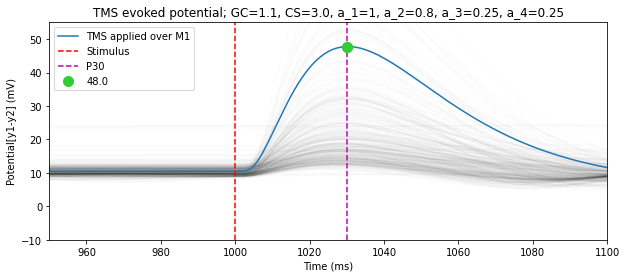

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


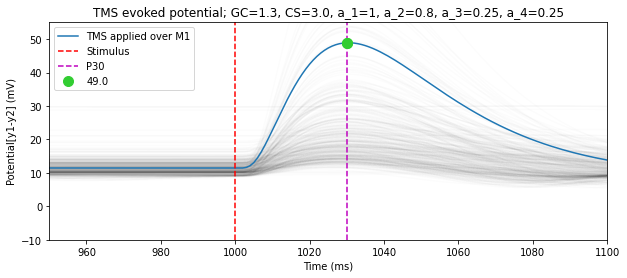

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


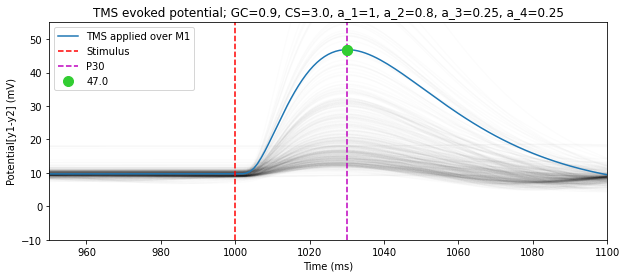

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


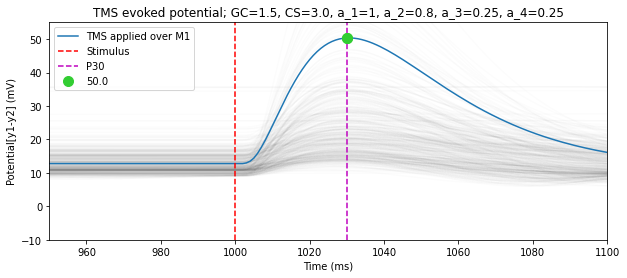

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


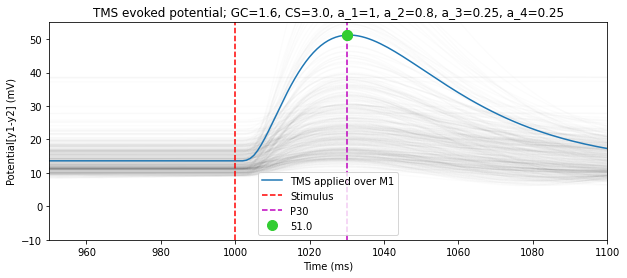

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


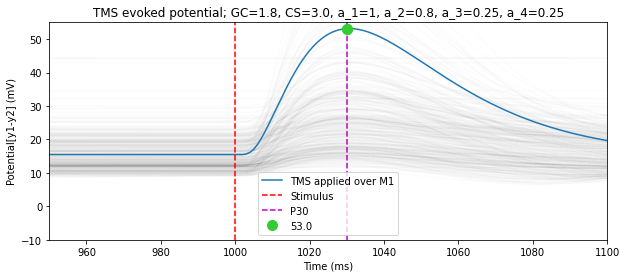

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of d

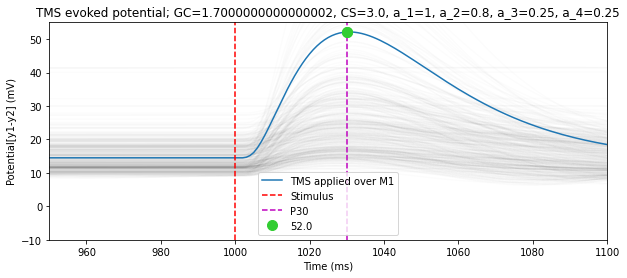

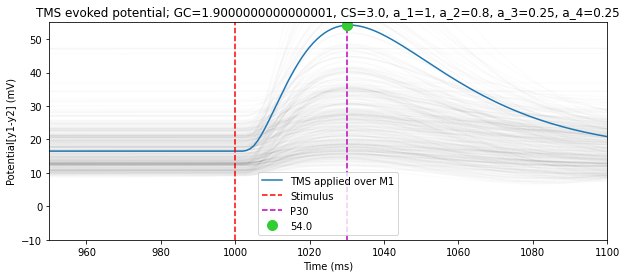

In [36]:
# import warnings
# warnings.filterwarnings('ignore')

import multiprocessing as mp
from itertools import repeat
n_cores = 4

# varying GC only
p = mp.Pool(processes=n_cores)
gc_range = np.arange(0, 2, .1)
results_gc = p.starmap(run_sim, zip(gc_range))
p.close()

WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in 

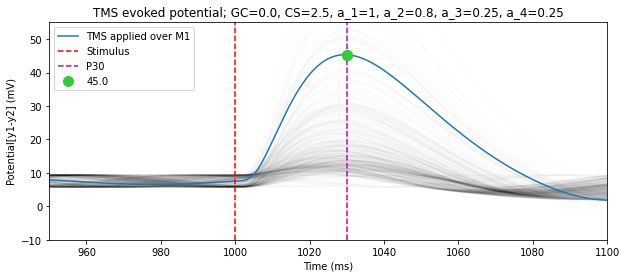

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


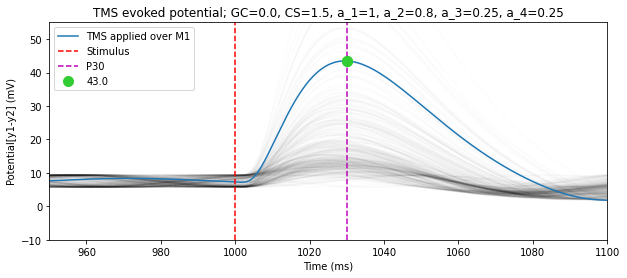

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


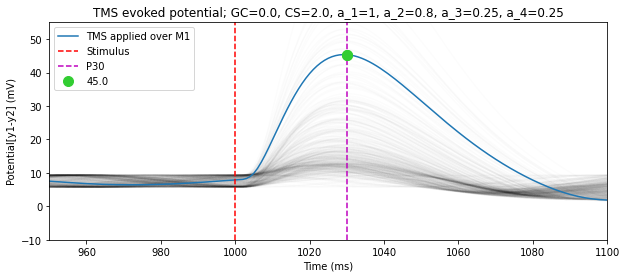

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


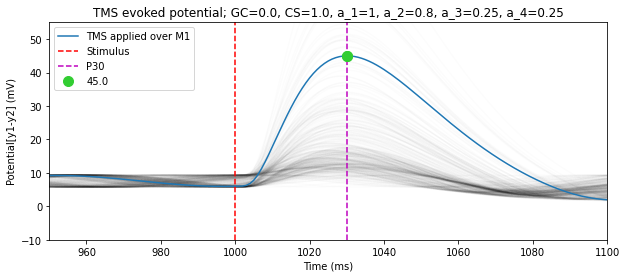

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


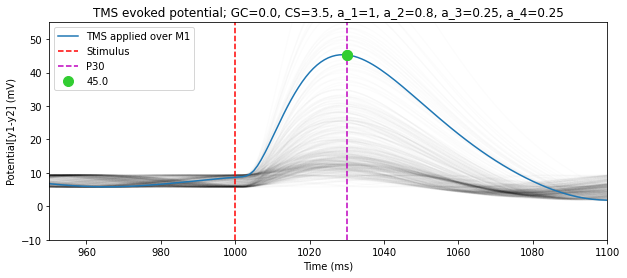

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


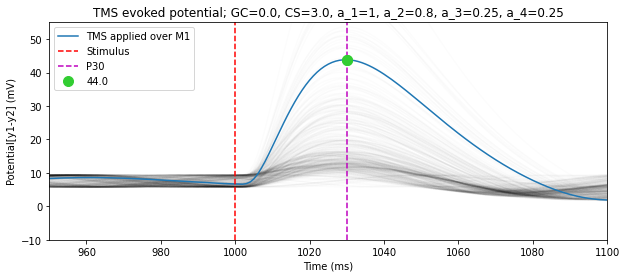

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


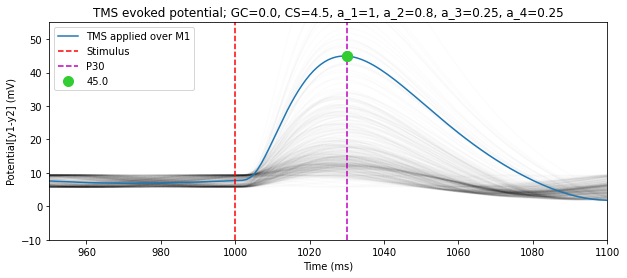

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


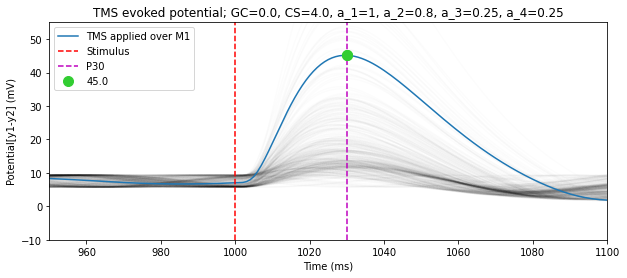

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


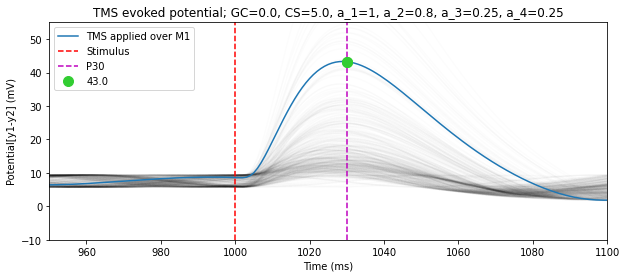

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


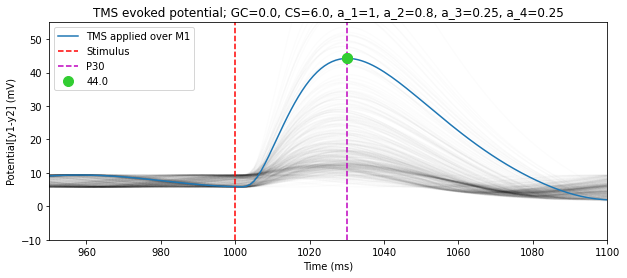

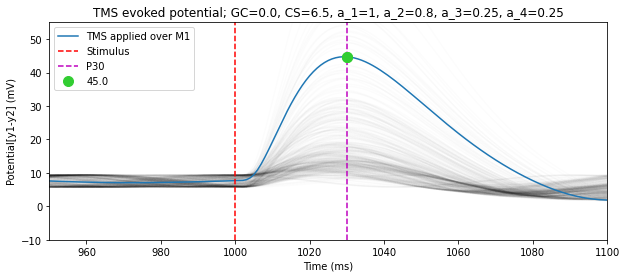

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


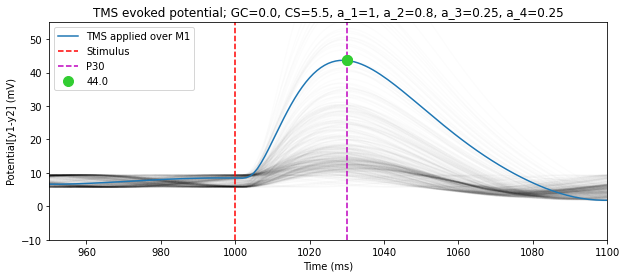

In [37]:
# varying conduction speed only
p = mp.Pool(processes=n_cores)
cs_range = np.arange(1,7,.5)
results_cs = p.starmap(run_sim, zip(repeat(0.0), cs_range))
p.close()

WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:,

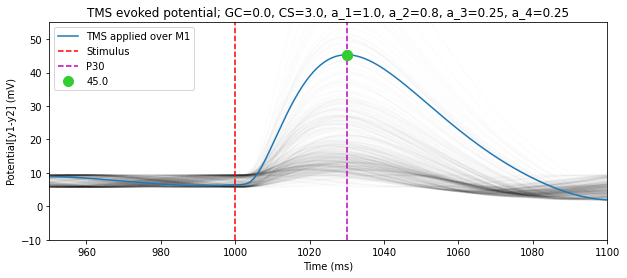

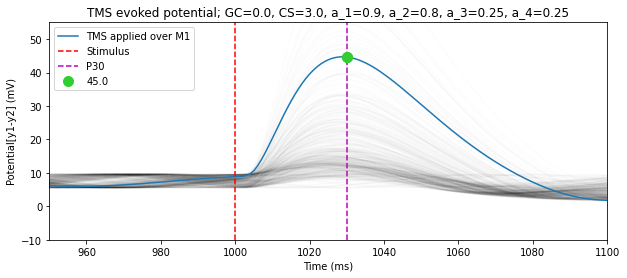

WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


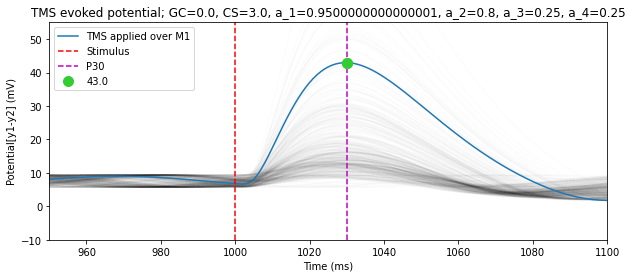

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


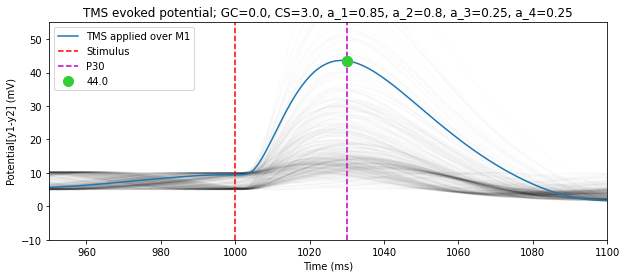

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


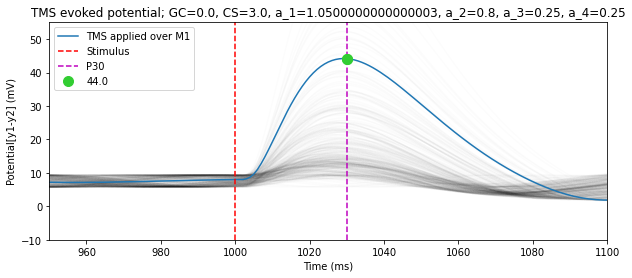

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


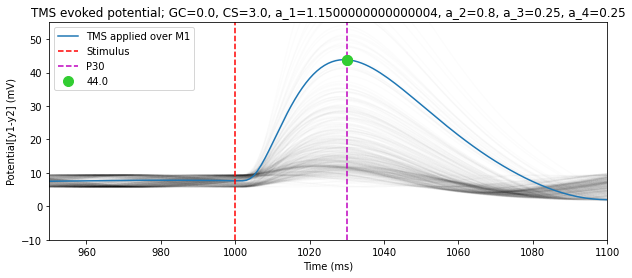

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


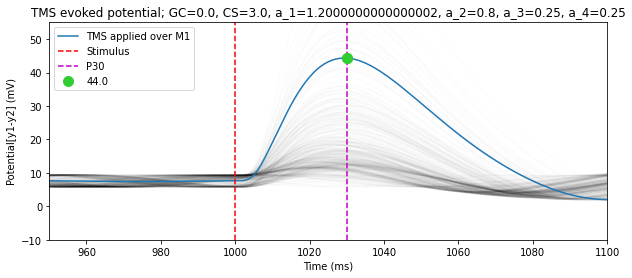

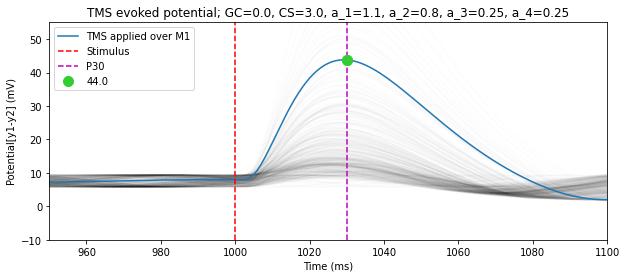

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


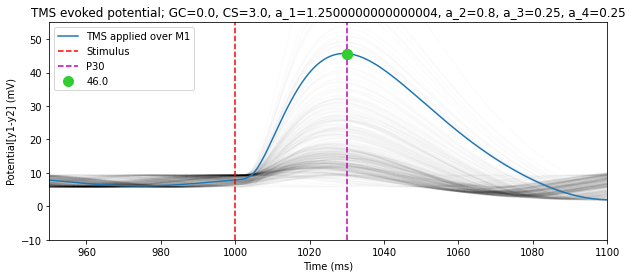

In [38]:
# varying a1
p = mp.Pool(processes=n_cores)
a1_range = np.arange(0.85,1.3,.05)
results_a1 = p.starmap(run_sim, zip(repeat(0.0), repeat(3.0), a1_range))
p.close()

WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **

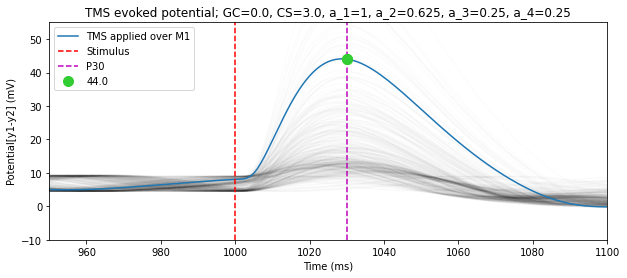

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


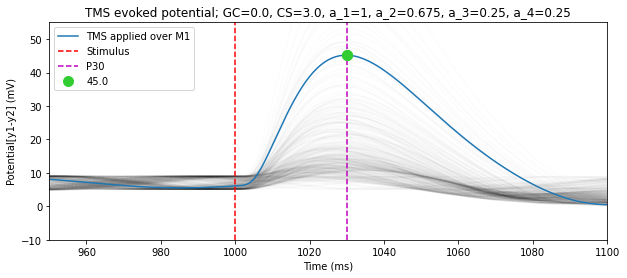

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


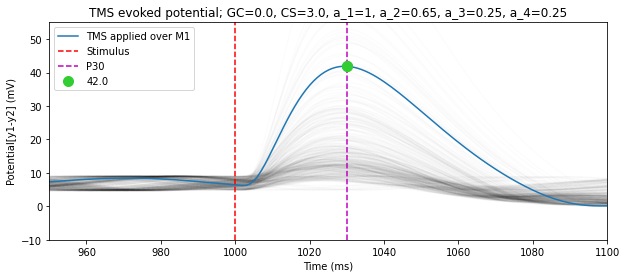

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


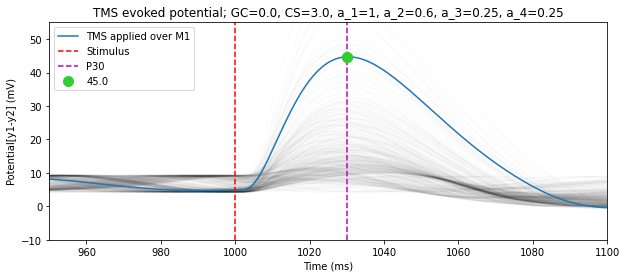

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from

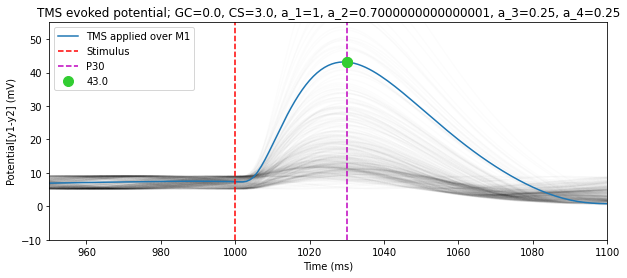

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


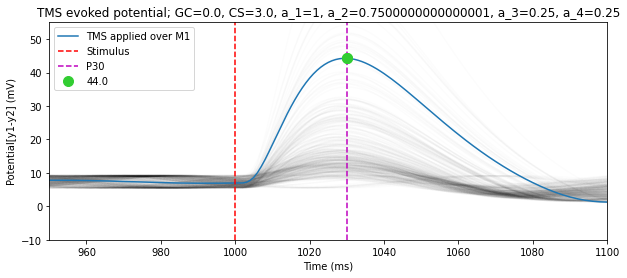

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


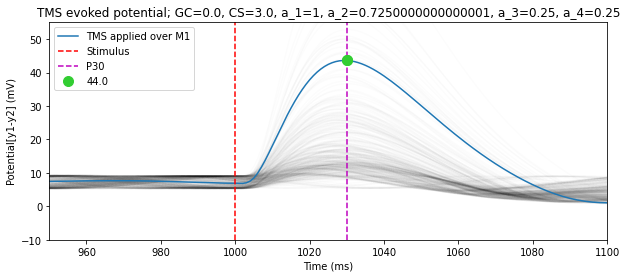

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


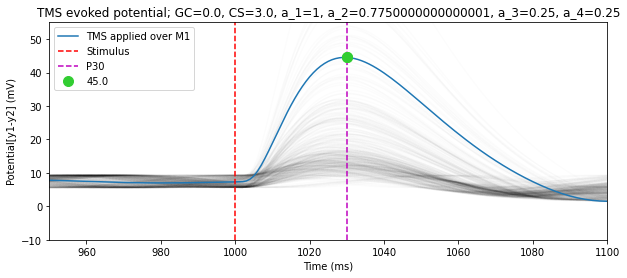

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


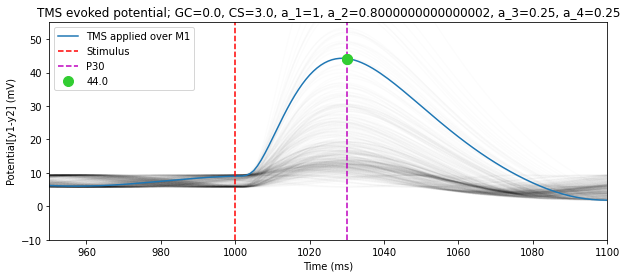

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


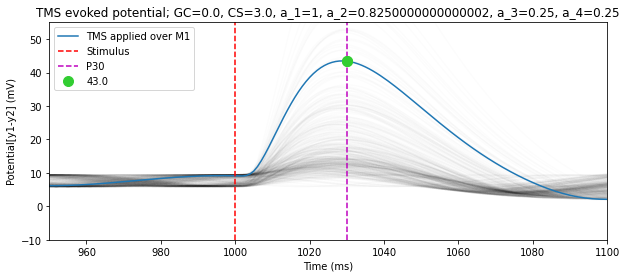

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


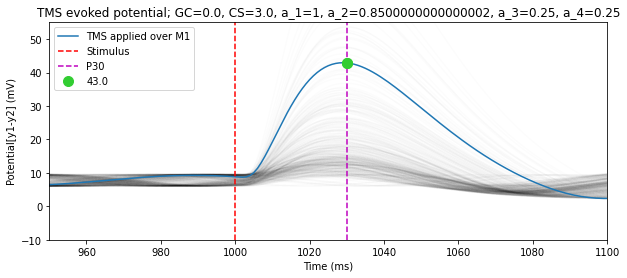

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


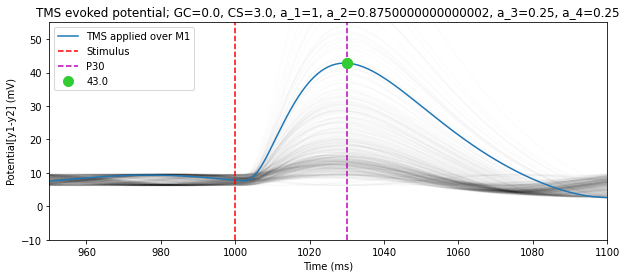

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


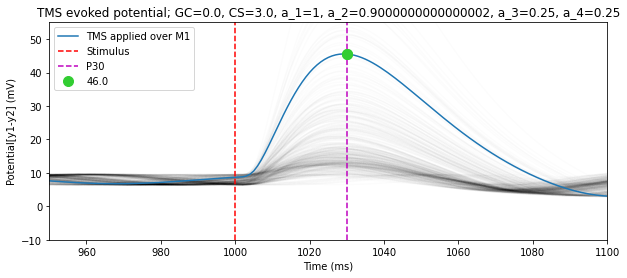

In [40]:
# varying a2
p = mp.Pool(processes=n_cores)
a2_range = np.arange(0.6,.9,.025)
results_a2 = p.starmap(run_sim, zip(repeat(0.0), repeat(3.0), repeat(1), a2_range))
p.close()


WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _

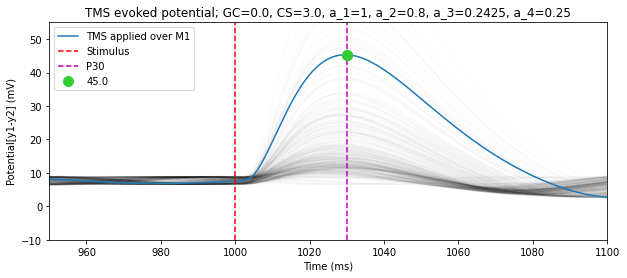

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


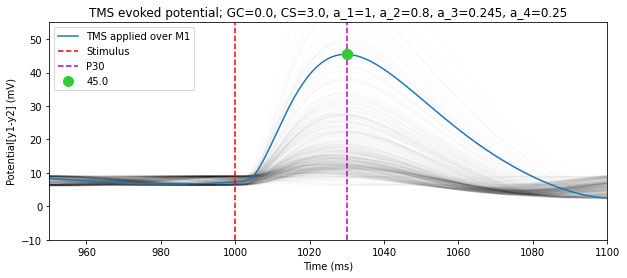

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


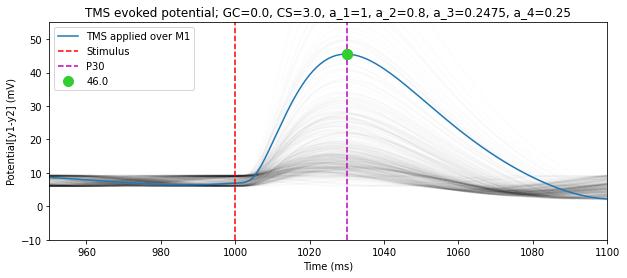

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


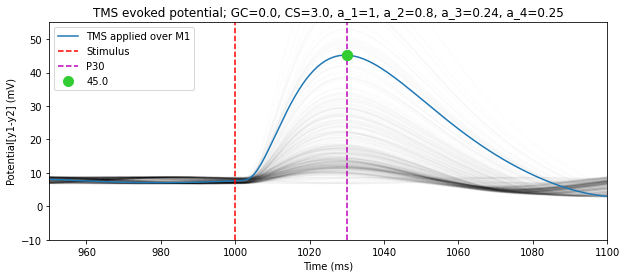

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from

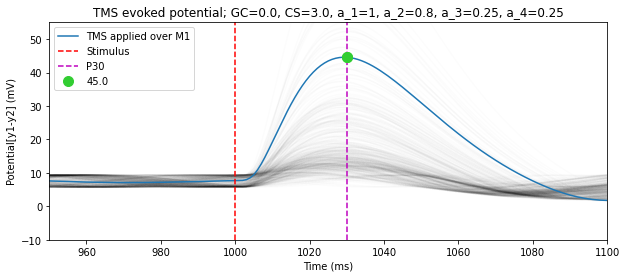

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


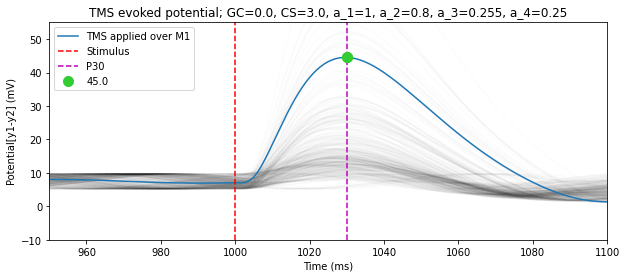

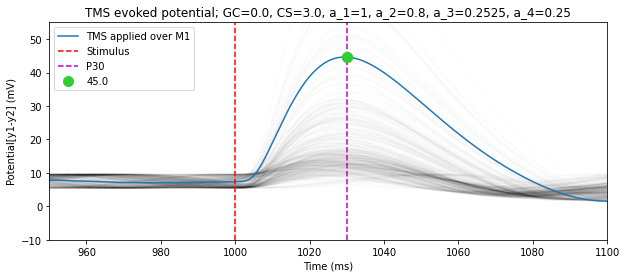

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


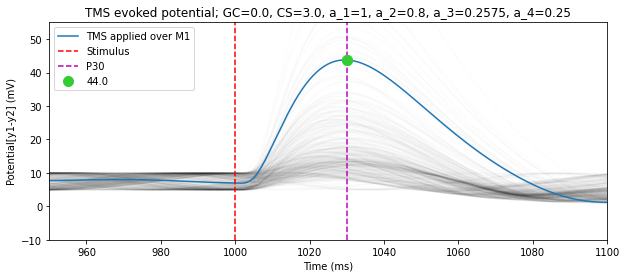

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


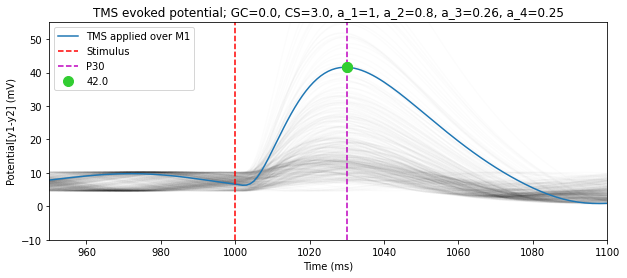

In [41]:

# varying a3
p = mp.Pool(processes=n_cores)
a3_range = np.arange(0.24,0.26,.0025)
results_a3 = p.starmap(run_sim, zip(repeat(0.0), repeat(3.0), repeat(1), repeat(0.8), a3_range))
p.close()


WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration
WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(se

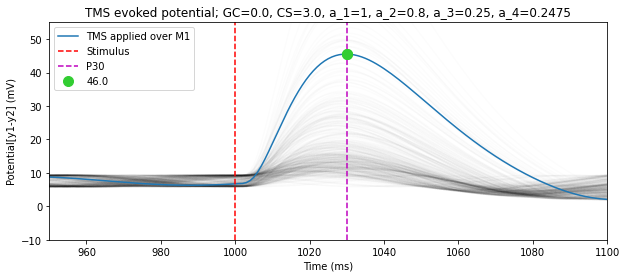

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


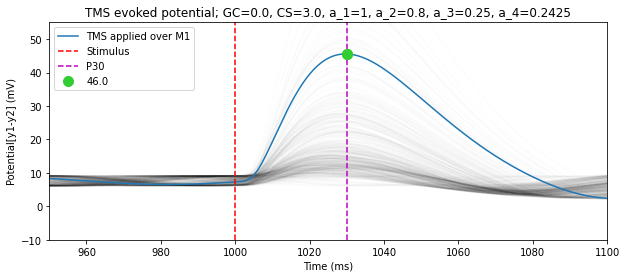

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))


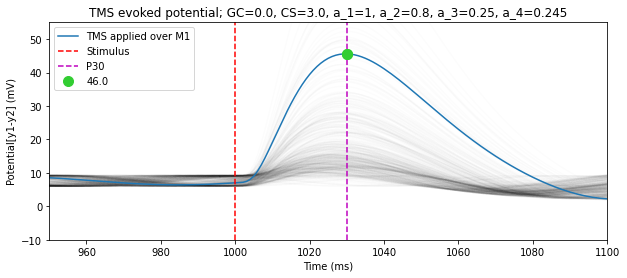

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


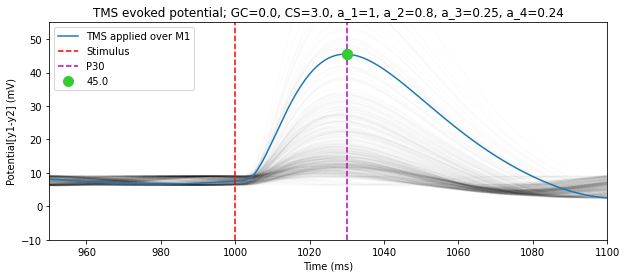

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from

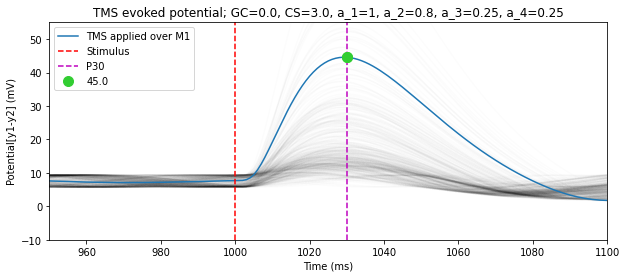

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


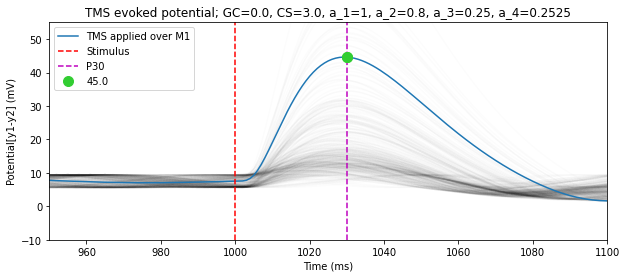

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


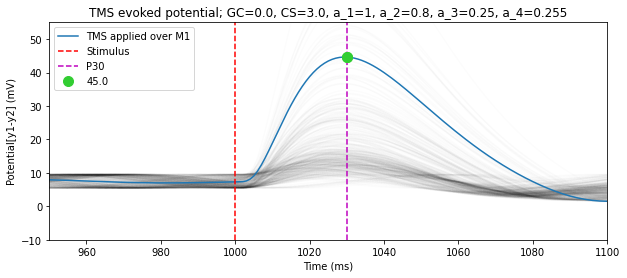

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


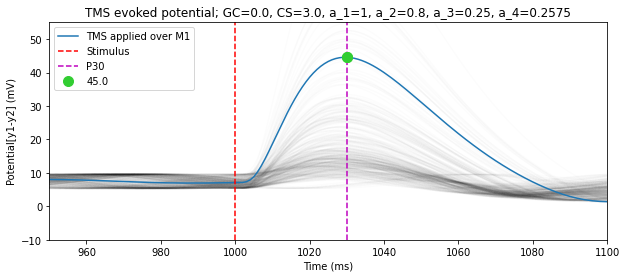

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


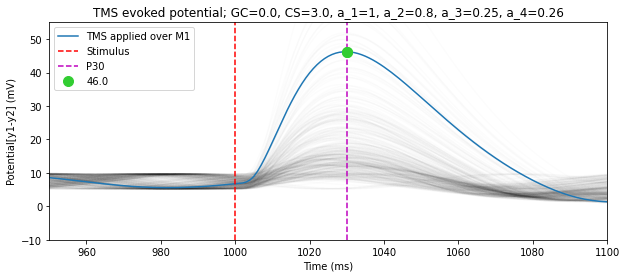

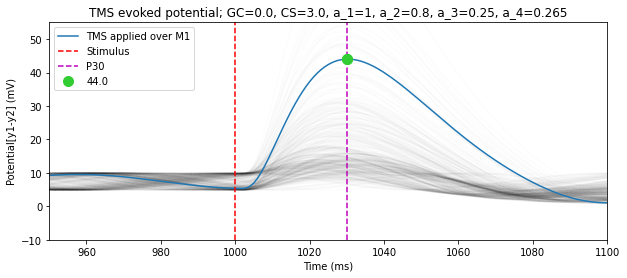

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


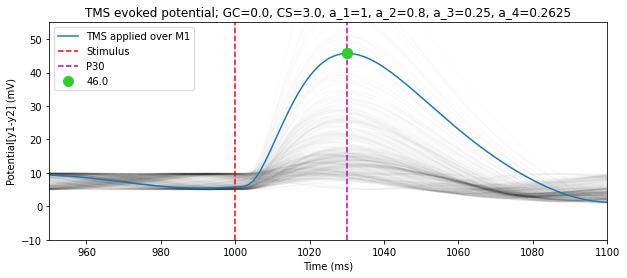

In [42]:

# varying a4
p = mp.Pool(processes=n_cores)
a4_range = np.arange(0.24,0.2650,.0025)
results_a4 = p.starmap(run_sim, zip(repeat(0.0), repeat(3.0), repeat(1), repeat(0.8), repeat(0.25), a4_range))
p.close()

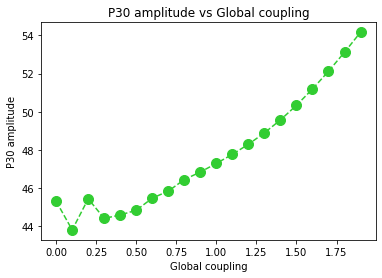

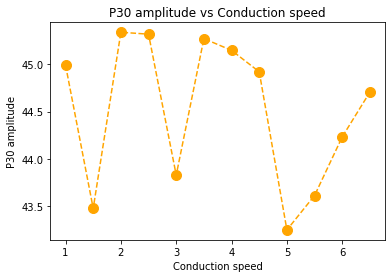

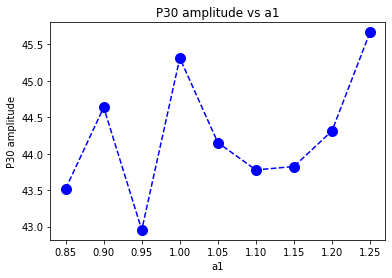

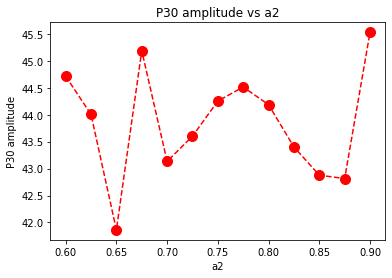

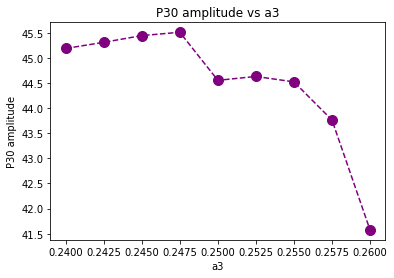

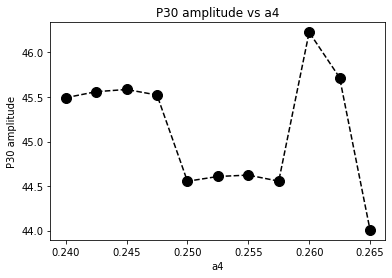

In [44]:

ranges = [gc_range, cs_range, a1_range, a2_range, a3_range, a4_range]
results = [results_gc, results_cs, results_a1, results_a2, results_a3, results_a4]
parameter_varied = ["Global coupling", "Conduction speed", "a1", "a2", "a3", "a4"]
color = ["limegreen", "orange", "blue", "red", "purple", "black"]

for idx, parameter in enumerate(parameter_varied):
    P30_amplitudes =np.array(results[idx])[:, 0]
    plt.plot(ranges[idx], P30_amplitudes, marker="o", ls="--", ms=10, color=color[idx])
    plt.xlabel(f"{parameter}")
    plt.ylabel("P30 amplitude")
    plt.title(f"P30 amplitude vs {parameter}")
    plt.show()